In [84]:
#%reset
"""
Definition of test problems
--------------------------------------------------------------------------
Created November 4 2023 for TRIPs-Py library
"""
__authors__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha and Connor Sanderford"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com and csanderf@asu.edu; connorsanderford@gmail.com"
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
from trips.operators import *
import time
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import numpy as np
import astra
from trips.phantoms import *
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
import scipy.special as spe
from trips.testProblems import *
from trips.operators import *
from trips.solvers.gks_all import *
from trips.solvers.Tikhonov import *
from trips.solvers.tSVD import *
from trips.helpers import *
from trips.operators import *

#### In this notebook we illustrate how to use the Tomography class. The main features are:
1. Define e tomography problem where the forward operator can be formed explicitly as a matrix
 - 1.1 We show how to use SVD, compute the singular values of the operator, and illustrate the truncated SVD solution
 - 1.2 We use regularization methods for computing an approximate solution
2. Define a tomography problem where the forward operator is defined as a function
3. Define a tomography problem by loading some saved data


#### 1. Define e tomography problem where the forward operator can be formed explicitly as a matrix

###### We define an operator, choose a phantom of any given size and plot the true phantom and the sinograpm as follows:

In [85]:
# Define an object of the class Tomogrpahy
Tomo = Tomography()
# Specify the dimensions of the phantom and the number of angels 
angels = 90
nx = 64
ny = 64
# Step 1: Define the operator as a matrix
Amat = Tomo.forward_Op_mat(nx, ny, angels)
# Step 2: Define the true solution. 
# Options are: grains, smooth, tectonic, threephases, ppower
testproblem = 'tectonic'
(x_true, nx, ny) = Tomo.gen_true(nx, ny, testproblem)
# Generate the data: We can skip Step 1 and generate the sinogram and the operator by the following lines
(A, b_true, p, q, AforMatrixOperation) = Tomo.gen_data(x_true, True, nx, ny, angels)
# Add noise in the true simulated sinogram b_true
# The opt defines the type of the noise. Options are Gaussian, Laplace, and Poisson
# The noise level defines the percentage of the noise added in the data. A value 0.1 means 10% additive noise
(b, e) = Tomo.add_noise(b_true = b_true, opt = 'Gaussian', noise_level = 0.001)

###### Display the true image, the sinogram without noise and the noisy sinogram

(<AxesSubplot:title={'center':'b'}>,
 Text(0.5, 1.0, 'b'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7ff761595a90>)

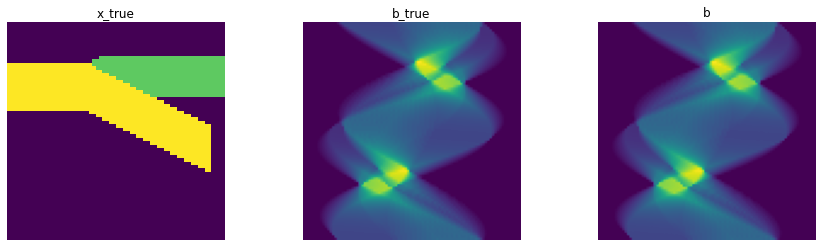

In [86]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('b_true'), plt.axis('off'), plt.imshow(b_true.reshape((p,q)))
plt.subplot(1,3,3), plt.title('b'), plt.axis('off'), plt.imshow(b.reshape((p,q)))

##### 1.1. Compute the SVD of the operartor $A$ and plot the singlar values and the singular vectors
###### If the parameter is 'A' then we give the full operator to the function plot_singular_values_svd. The SVD is then computed and the singlar values are plotted. If the parameter is 'S' then we have precomputed the SVD from which we have S and the function plot_singular_values_svd will only plot the singular values. The same applies for plotting the singular vectors. If the operaror is not given, we give the matrix V.

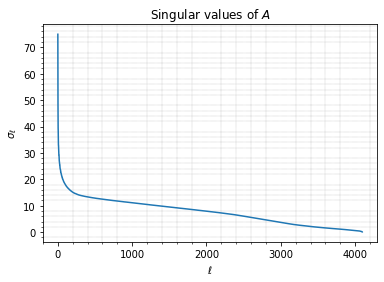

In [83]:
# If the operator is sparse, we convert it to dense
plot_singular_values_svd(Operator = A.todense(), parameter = 'A')
# If the operator is in the matrix form, but very large and sparse, the following commands can be used to compute the SVD
# import scipy
# [U, S, V] = scipy.sparse.linalg.svds(A, 100)
# 100 defines the number of singular values to be computed

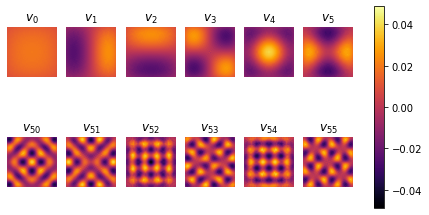

In [82]:
plot_singular_vectors_svd(Operator = A.todense(), size = nx, parameter = 'A')

##### 1.1. Compute the truncated SVD solution of a problem by specifying how many singular values you want to keep after truncation

(-0.5, 63.5, 63.5, -0.5)

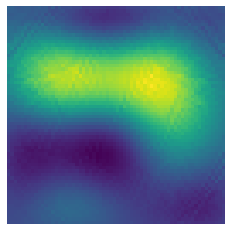

In [81]:
truncated_value = 15
b_vec = b.reshape((-1,1))
x_tsvd = TruncatedSVD_sol(A.todense(), truncated_value, b_vec)
plt.imshow(x_tsvd.reshape((nx, ny)))
plt.axis('off')

#### 1.2 Compute an approximate solution by using Generalized Krylov Subspace method (GKS)

In [78]:
# First we compute a naive solution
x_naive = A.T@b.reshape((-1,1))

In [79]:
# Define a derivative operator as a regularization operator
L = spatial_derivative_operator(nx, ny, 1)
data_vec = b.reshape((-1,1))
# Use GKS to compute an approximate solution
(x_gks, info) = GKS(A, data_vec, L, projection_dim=3, n_iter = 10, regparam = 1, x_true = x_true.reshape(-1,1))

running GKS...: 100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


(<AxesSubplot:title={'center':'x_gks'}>,
 Text(0.5, 1.0, 'x_gks'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x7ff7ad5bb370>)

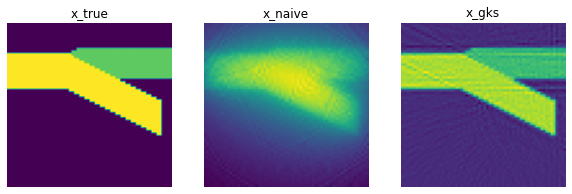

In [80]:
# Display the true desired vs the naive computed solution and vs the approximate regularized computed solution 
plt.figure(figsize=(10,4))
plt.subplot(1,3,1), plt.title('x_true'), plt.axis('off'), plt.imshow(x_true.reshape((nx,ny)))
plt.subplot(1,3,2), plt.title('x_naive'), plt.axis('off'), plt.imshow(x_naive.reshape((nx,ny)))
plt.subplot(1,3,3), plt.title('x_gks'), plt.axis('off'), plt.imshow(x_gks.reshape((nx, ny)))

##### Illustrate the ill-posedness of some inverse problem examples and show the need for regularization
<p>In this example we illustrate the following:

Step 1: Generate a small tomography example


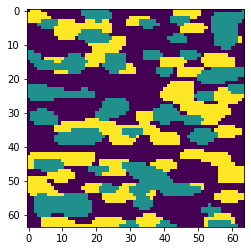

In [2]:
x = threephases(64)
plt.imshow(x)

In [8]:
import scipy
scipy.__version__

'1.9.0'

In [6]:
# Tomography test problem
sizex = 64
sizey = 64
Tomo = Tomography(sizex = sizex, sizey = sizey)
# To generate a small scale problem, set generate_matrix = True, otherwise generate_matrix = False
generate_matrix = True
if generate_matrix == True:
        A = Tomo.forward_Op_mat(sizex, sizey)
else:
        A = Tomo.forward_Op(sizex, sizey)

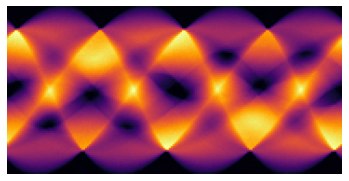

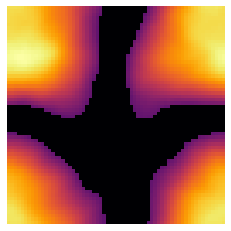

<Figure size 432x288 with 0 Axes>

In [7]:
testproblem = 'ppower'
x_true = Tomo.generate_true(test_problem = testproblem)
shape = (np.int0(np.sqrt(x_true.shape[0])), np.int0(np.sqrt(x_true.shape[0])))
b_true = Tomo.generate_data(x_true, 1, 'simulated')
(b, delta) = Tomo.add_noise(b_true, 'Gaussian', noise_level= 0.01)
Tomo.plot_sino(b)
Tomo.plot_rec(x_true.reshape((shape), order = 'F'), save_imgs = False, save_path='./saveImagesTomography'+'rec')

Step 2: Find the naive solution of 
$\mathbf A{\mathbf x} = {\mathbf b}$ and plot the solution

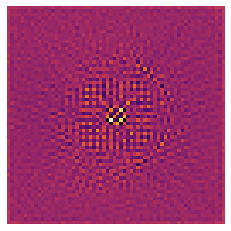

<Figure size 432x288 with 0 Axes>

In [8]:
# vectorize the available measurements
b_vec = b.reshape((-1,1))
# Compute the (pseudo)inverse of the operator
A_inv = np.linalg.pinv(A.todense())
# Show the reconstruction of the least squares problem
Tomo.plot_rec(A_inv*b_vec, save_imgs = True, save_path='./saveImagesTomo')

Analyze the singular value expansion of the forward operator

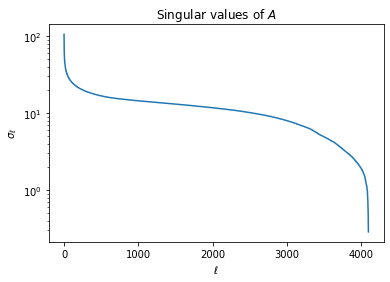

In [24]:
U, S, VT = np.linalg.svd(A.todense())
V = VT.T
plt.semilogy(S)
plt.title('Singular values of $A$')
plt.xlabel('$\ell$')
plt.ylabel('$\sigma_{\ell}$')
plt.savefig('singular_values.png', bbox_inches='tight')
plt.show()


Step 3: Solve the regularized problem

$\|\mathbf A{\mathbf x} - {\mathbf b}\|_2 + \lambda \|\mathbf L\mathbf x\|_q$ with $\mathbf L$ is the discretization of the two-dimensional first derivative operator, for an optimal value of $\lambda$. The value of $q$ can be choosen from (0, 2].

#### Step 4: Solve the problem by Golub-Kahan

generating basis...: 100%|██████████| 10/10 [00:00<00:00, 165.39it/s]

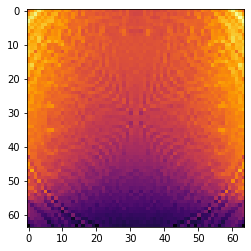

In [6]:
b_vec = b.reshape((-1,1))
projection_dim = 10
(U, B, V) = generalized_golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
x_GKahan = np.reshape(x_GKahan, shape)
x_GKahan.shape
plt.imshow(x_GKahan)

In [9]:
from trips.solvers.gks import *
L = first_derivative_operator_2d(nx= sizex, ny = sizey)
# MMGKS(A, b, L, pnorm=1, qnorm=1, projection_dim=3, iter=50, regparam='gcv', x_true=None, **kwargs):
(x_MMGKS) = MMGKS(A, b_vec, L, pnorm = 2, qnorm = 1, projection_dim= 10, n_iter = 10, regparam = 1, delta = delta)
    #    GKS(A, b, L, projection_dim=3, iter=50, selection_method = 'gcv', **kwargs):

generating basis...:   0%|          | 0/10 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 10/10 [00:01<00:00,  9.59it/s]
